# Reconhecimento de Imagens usando TensorflowOnSpark

## Exemplo reconhecimento  de espécies de flores

Este exemplo lê um diretório de imagens, cria um vetor de features e inclui um tag de identificação.

Cada diretório pode comnter qualquer numero de imagens, no entanto, é obrigatório que cada diretório possua apenas uma categoria de imagem.

In [1]:
# Load libs
import findspark
findspark.init()

from pyspark import SparkContext
from pyspark.sql import SparkSession

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.image import ImageSchema

import tensorflow as tf
import tensorflowonspark as tfos

from tensorflow.keras import layers, models, utils
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3

from tensorflowonspark import compat, TFNode, TFCluster
from pyspark.conf import SparkConf

import argparse
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
from time import perf_counter

AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.3.0'

In [2]:
tfos.__version__

'2.2.1'

In [3]:
# Set main images directory
data_repo = "/data/dataset/flower_photos/"

TRAIN_SAMPLE = 0.8
TEST_SAMPLE = 0.2
BATCH_SIZE = 10
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=8

# Set base directory (where are all flower's directories)
data_dir = pathlib.Path(data_repo)
print(data_dir)

/data/dataset/flower_photos


In [4]:
# Starting Spark Cluster with Docker
spark = SparkSession.builder\
        .appName("FlowerID_TF_TensorflowOnSpark") \
        .master("mesos://zk://10.129.64.20:2181,10.129.64.10:2181,10.129.64.30:2181/mesos") \
        .config("spark.mesos.executor.docker.image","lasid/spark-worker-tensorflow:2.4.6_bionic") \
        .config("spark.mesos.containerizer","docker") \
        .getOrCreate()

spark.conf.set("spark.submit.deployMode", "client")

# create the Spark Context
sc = spark.sparkContext

strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/device:CPU:0',)


2020-08-17 21:57:55,049 INFO (MainThread-20498) Using MirroredStrategy with devices ('/device:CPU:0',)


INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO


2020-08-17 21:57:55,058 INFO (MainThread-20498) Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:CPU:0',), communication = CollectiveCommunication.AUTO


In [5]:
#configurations = spark.sparkContext.getConf().getAll()

#for conf in configurations:
#    print(conf)

## Bibliotecas úteis

In [6]:
# Some usefull libs to read and prepare images

def get_label(file_path):
    # Get directory name,, i.e., flower specie 
    parts = tf.strings.split(file_path, '/')
    # Check file path and return label
    return parts[-2] == CLASS_NAMES

def decode_img(img):
    # Decode jpeg image
    img = tf.image.decode_jpeg(img, channels=3) #color images
    # Convert unit8 tensor to floats in the [0,1]range
    img = tf.image.convert_image_dtype(img, tf.float32) 
    # Resize the image  
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

def process_path(file_path):
    # Get label
    label = get_label(file_path)
    # Get image file and convert to tensor
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # Test if images are on cache and use it
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')
    plt.show() 

In [7]:
def main_fun(args, ctx):
#  import tensorflow_datasets as tfds
    import tensorflow as tf
    from tensorflowonspark import compat

#  tfds.disable_progress_bar()
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

    BUFFER_SIZE = args.buffer_size
    BATCH_SIZE = args.batch_size
    NUM_WORKERS = args.cluster_size
    EPOCHS = args.epochs
    TRAIN_SAMPLE = args.train_sample
    TEST_SAMPLE = 1 - TRAIN_SAMPLE
    GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS
    
  # Scaling MNIST data from (0, 255] to (0., 1.]
  #def scale(image, label):
  #  return tf.cast(image, tf.float32) / 255, label

  # workaround for https://github.com/tensorflow/datasets/issues/1405
  #datasets = tfds.load(name='mnist', split='train', as_supervised=True)
    #options = tf.data.Options()
    #options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    #train_datasets_unbatched = datasets.with_options(options).repeat().map(scale).shuffle(BUFFER_SIZE)

    def get_label(file_path):
        # Get directory name,, i.e., flower specie 
        parts = tf.strings.split(file_path, '/')
        # Check file path and return label
        return parts[-2] == CLASS_NAMES

    def decode_img(img):
        # Decode jpeg image
        img = tf.image.decode_jpeg(img, channels=3) #color images
        # Convert unit8 tensor to floats in the [0,1]range
        img = tf.image.convert_image_dtype(img, tf.float32) 
        # Resize the image  
        return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT]) 

    def process_path(file_path):
        # Get label
        label = get_label(file_path)
        # Get image file and convert to tensor
        img = tf.io.read_file(file_path)
        img = decode_img(img)
        return img, label

    def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
        # Test if images are on cache and use it
        if cache:
            if isinstance(cache, str):
                ds = ds.cache(cache)
            else:
                ds = ds.cache()
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
        ds = ds.repeat()
        ds = ds.batch(BATCH_SIZE)
        # `prefetch` lets the dataset fetch batches in the background
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds
    
    def build_and_compile_cnn_model():
        model = models.Sequential([
            layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
            layers.MaxPooling2D(),
            layers.Conv2D(32, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, padding='same', activation='relu'),
            layers.MaxPooling2D(),
            layers.Flatten(),
            layers.Dense(5, activation='relu'),
            layers.Dense(5)
        ])

        model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        return model
        


      # single node
      # single_worker_model = build_and_compile_cnn_model()
      # single_worker_model.fit(x=train_datasets, epochs=3)

      # Here the batch size scales up by number of workers since
      # `tf.data.Dataset.batch` expects the global batch size. Previously we used 64,
      # and now this becomes 128.


 #   train_datasets = train_ds.batch(GLOBAL_BATCH_SIZE)

      # this fails
      # callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=args.model_dir)]
#    tf.io.gfile.makedirs(args.model_dir)
#    filepath = args.model_dir + "/weights-{epoch:04d}"
#    callbacks = [
#        tf.keras.callbacks.ModelCheckpoint(filepath=filepath, verbose=1, save_weights_only=True),
#        tf.keras.callbacks.TensorBoard(log_dir=args.model_dir)
#    ]

    # Read all images files and set Tensor
    list_ds = tf.data.Dataset.list_files(str(args.data_dir/'*/*'))

    with strategy.scope():
        labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
        images_ds = prepare_for_training(labeled_ds)
        train_ds = images_ds.take(int(TRAIN_SAMPLE*SIZE_OF_DATASET))
        test_ds = images_ds.skip(int(TEST_SAMPLE*SIZE_OF_DATASET))
        train_images, train_labels = next(iter(train_ds))
        test_images, test_labels = next(iter(test_ds))
        multi_worker_model = build_and_compile_cnn_model()
        multi_worker_model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))
        
#    multi_worker_model.fit(x=train_datasets, epochs=args.epochs, steps_per_epoch=args.steps_per_epoch, callbacks=callbacks)

#    from tensorflow_estimator.python.estimator.export import export_lib
#    export_dir = export_lib.get_timestamped_export_dir(args.export_dir)
#    compat.export_saved_model(multi_worker_model, export_dir, ctx.job_name == 'chief')


## Leitura images do repositorio

In [8]:
# Count the number of flower images and set dataset size
SIZE_OF_DATASET = len(list(data_dir.glob('*/*.jpg')))

print("Number of images: ",SIZE_OF_DATASET)

Number of images:  4510


In [9]:
# Get the Class names reading directory names
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
#CLASS_NAMES = list([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['dandelion' 'daisy' 'sunflower' 'rose' 'tulip']


In [10]:
# Read all images files and set Tensor
#list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

#for f in list_ds.take(5):
#    print(f.numpy())

In [11]:
# Process images
start_time = perf_counter()

#image_df = ImageSchema.readImages("/data/myimages")

#labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#images_ds = prepare_for_training(labeled_ds)

In [12]:
# Split train and test sample
#train_ds = images_ds.take(int(TRAIN_SAMPLE*SIZE_OF_DATASET))
#test_ds = images_ds.skip(int(TEST_SAMPLE*SIZE_OF_DATASET))

#train_images, train_labels = next(iter(train_ds))
#test_images, test_labels = next(iter(test_ds))

#print("train image: ", tf.size(train_images))
#print("train labels: ", tf.size(train_labels))

#time_ip = perf_counter() - start_time
#tf.print("Image processing time:", time_ip)

In [13]:
#image_batch, label_batch = next(iter(train_ds))
#show_batch(image_batch.numpy(), label_batch.numpy())

In [14]:
executors = sc._conf.get("spark.executor.instances")
num_executors = int(executors) if executors is not None else 1
num_executors = 3

In [15]:
parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", help="number of records per batch", type=int, default=BATCH_SIZE)
parser.add_argument("--buffer_size", help="size of shuffle buffer", type=int, default=10000)
parser.add_argument("--cluster_size", help="number of nodes in the cluster", type=int, default=num_executors)
parser.add_argument("--epochs", help="number of epochs", type=int, default=EPOCHS)
parser.add_argument("--train_sample", help="percentage of train sample", type=int, default=TRAIN_SAMPLE)
parser.add_argument("--model_dir", help="path to save model/checkpoint", default="./model")
#parser.add_argument("--export_dir", help="path to export saved_model", default="mnist_export")
parser.add_argument("--data_dir", help="path to data dir", default=data_dir)
parser.add_argument("--steps_per_epoch", help="number of steps per epoch", type=int, default=469)
parser.add_argument("--tensorboard", help="launch tensorboard process", action="store_true")



args, unknown = parser.parse_known_args()
#args = parser.parse_args()
print("args:", args)

args: Namespace(batch_size=10, buffer_size=10000, cluster_size=3, data_dir=PosixPath('/data/dataset/flower_photos'), epochs=8, model_dir='./model', steps_per_epoch=469, tensorboard=False, train_sample=0.8)


In [16]:
# cluster = TFCluster.run(sc, main_fun, args, args.cluster_size, num_ps=0, tensorboard=args.tensorboard, input_mode=TFCluster.InputMode.TENSORFLOW, master_node='chief', log_dir=args.model_dir)    

cluster = TFCluster.run(sc, main_fun, args, args.cluster_size, num_ps=0, input_mode=TFCluster.InputMode.TENSORFLOW)

2020-08-17 21:58:12,053 INFO (MainThread-20498) Reserving TFSparkNodes 
2020-08-17 21:58:12,056 INFO (MainThread-20498) cluster_template: {'worker': [0, 1, 2]}
2020-08-17 21:58:12,062 INFO (MainThread-20498) Reservation server binding to port 0
2020-08-17 21:58:12,063 INFO (MainThread-20498) listening for reservations at ('10.129.64.30', 42577)
2020-08-17 21:58:12,066 INFO (MainThread-20498) Starting TensorFlow on executors
2020-08-17 21:58:12,235 INFO (MainThread-20498) Waiting for TFSparkNodes to start
2020-08-17 21:58:12,237 INFO (MainThread-20498) waiting for 3 reservations
2020-08-17 21:58:13,242 INFO (MainThread-20498) waiting for 3 reservations
2020-08-17 21:58:14,245 INFO (MainThread-20498) waiting for 3 reservations
2020-08-17 21:58:15,248 INFO (MainThread-20498) waiting for 3 reservations
2020-08-17 21:58:16,251 INFO (MainThread-20498) waiting for 1 reservations
2020-08-17 21:58:17,255 INFO (MainThread-20498) all reservations completed
2020-08-17 21:58:17,257 INFO (MainThread

In [17]:
# Stop all
cluster.shutdown()
spark.stop()

2020-08-17 21:58:22,575 INFO (MainThread-20498) Waiting for TensorFlow nodes to complete...
2020-08-17 21:58:44,279 INFO (MainThread-20498) Shutting down cluster


# Create Convolutional Neural Network (CNN) Model

## Modelo Simples 

In [11]:
start_time = perf_counter()

model = models.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(5, activation='relu'),
    layers.Dense(5)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0

In [12]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 0s 170ms/step - loss: 1.6036 - accuracy: 0.2000 - val_loss: 2.0321 - val_accuracy: 0.3000
Epoch 2/8
1/1 [==============================] - 0s 51ms/step - loss: 2.2155 - accuracy: 0.3000 - val_loss: 1.6189 - val_accuracy: 0.3000
Epoch 3/8
1/1 [==============================] - 0s 48ms/step - loss: 1.4717 - accuracy: 0.3000 - val_loss: 1.6065 - val_accuracy: 0.3000
Epoch 4/8
1/1 [==============================] - 0s 53ms/step - loss: 1.3453 - accuracy: 0.6000 - val_loss: 1.6245 - val_accuracy: 0.4000
Epoch 5/8
1/1 [==============================] - 0s 42ms/step - loss: 1.3079 - accuracy: 0.6000 - val_loss: 1.6415 - val_accuracy: 0.3000
Epoch 6/8
1/1 [==============================] - 0s 52ms/step - loss: 1.2645 - accuracy: 0.7000 - val_loss: 1.6340 - val_accuracy: 0.3000
Epoch 7/8
1/1 [==============================] - 0s 49ms/step - loss: 1.1926 - accuracy: 0.6000 - val_loss: 1.6401 - val_accuracy: 0.3000
Epoch 8/8
1/1 [==================

### Evaluating the Simple CNN Model Performance

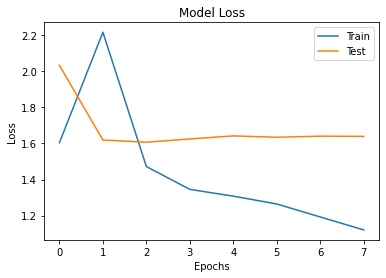

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

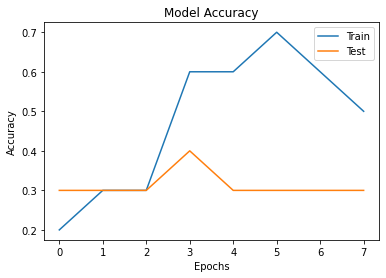

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [15]:
train_loss_sm, train_acc_sm = model.evaluate(train_images, train_labels, verbose=2)
test_loss_sm, test_acc_sm = model.evaluate(test_images, test_labels, verbose=2)
time_sm = perf_counter() - start_time
print(time_sm)

1/1 - 0s - loss: 1.0836 - accuracy: 0.3000
1/1 - 0s - loss: 1.6388 - accuracy: 0.3000
2.5694191090005916


## Modelo Complexo 

In [16]:
start_time = perf_counter()

model = models.Sequential([
# layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), name='conv_1'),
    layers.Conv2D(32, (3,3), activation='relu', name='conv_2'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_1'),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3,3), padding='same', activation='relu', name='conv_3'),
    layers.Conv2D(64, (3,3), activation='relu', name='conv_4'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_2'),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3,3), padding='same', activation='relu', name='conv_5'),
    layers.Conv2D(128, (3,3), activation='relu', name='conv_6'),
    layers.MaxPooling2D(pool_size=(2,2), name='maxpool_3'),
    layers.Flatten(),
    layers.Dense(512, activation='relu', name='dense_1'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', name='dense_2'),
    layers.Dense(len(CLASS_NAMES), name='output'),
    layers.Activation('softmax')
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 222, 222, 32)      9248      
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 111, 111, 64)      18496     
_________________________________________________________________
conv_4 (Conv2D)              (None, 109, 109, 64)      36928     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 54, 54, 64)       

In [17]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 0s 279ms/step - loss: 1.6079 - accuracy: 0.2000 - val_loss: 1.5944 - val_accuracy: 0.3000
Epoch 2/8
1/1 [==============================] - 0s 128ms/step - loss: 1.4579 - accuracy: 0.5000 - val_loss: 1.5956 - val_accuracy: 0.4000
Epoch 3/8
1/1 [==============================] - 0s 121ms/step - loss: 1.5760 - accuracy: 0.3000 - val_loss: 1.6048 - val_accuracy: 0.3000
Epoch 4/8
1/1 [==============================] - 0s 114ms/step - loss: 1.6047 - accuracy: 0.3000 - val_loss: 1.6048 - val_accuracy: 0.3000
Epoch 5/8
1/1 [==============================] - 0s 115ms/step - loss: 1.6048 - accuracy: 0.3000 - val_loss: 1.6048 - val_accuracy: 0.3000
Epoch 6/8
1/1 [==============================] - 0s 144ms/step - loss: 1.6048 - accuracy: 0.3000 - val_loss: 1.6048 - val_accuracy: 0.3000
Epoch 7/8
1/1 [==============================] - 0s 153ms/step - loss: 1.6048 - accuracy: 0.3000 - val_loss: 1.6048 - val_accuracy: 0.3000
Epoch 8/8
1/1 [============

### Evaluating the Complex CNN Model Performance

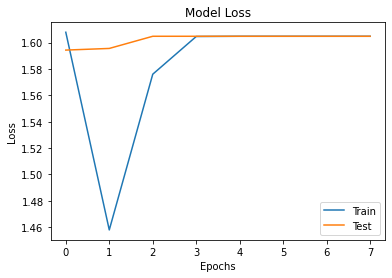

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

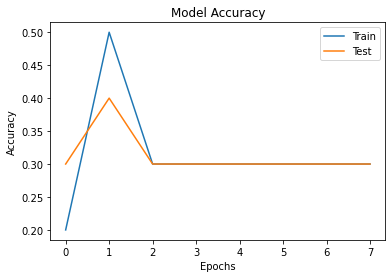

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [20]:
train_loss_cm, train_acc_cm = model.evaluate(train_images, train_labels, verbose=2)
test_loss_cm, test_acc_cm = model.evaluate(test_images, test_labels, verbose=2)
time_cm = perf_counter() - start_time
print(time_cm)

1/1 - 0s - loss: 1.6048 - accuracy: 0.3000
1/1 - 0s - loss: 1.6048 - accuracy: 0.3000
9.150911243021255


## Modelo VGG19

In [21]:
start_time = perf_counter()

pre_trained_model = VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3), include_top=False, weights="imagenet")

#pre_trained_model.trainable = False
for layer in pre_trained_model.layers[:19]:
    layer.trainable = False

# creating the final model  
model = models.Sequential([
    pre_trained_model,
    layers.MaxPool2D((2,2) , strides = 2),
    layers.Flatten(),
    layers.Dense(len(CLASS_NAMES) , activation='softmax')
])

#model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

#model.compile(optimizer='adam',
#              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
#              metrics=['accuracy'])


model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 512)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


In [22]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 1s 724ms/step - loss: 1.6357 - accuracy: 0.1000 - val_loss: 1.3872 - val_accuracy: 0.6000
Epoch 2/8
1/1 [==============================] - 1s 598ms/step - loss: 1.0380 - accuracy: 0.8000 - val_loss: 1.4332 - val_accuracy: 0.5000
Epoch 3/8
1/1 [==============================] - 1s 552ms/step - loss: 0.9082 - accuracy: 1.0000 - val_loss: 1.5213 - val_accuracy: 0.3000
Epoch 4/8
1/1 [==============================] - 1s 558ms/step - loss: 0.9058 - accuracy: 1.0000 - val_loss: 1.5635 - val_accuracy: 0.3000
Epoch 5/8
1/1 [==============================] - 1s 579ms/step - loss: 0.9049 - accuracy: 1.0000 - val_loss: 1.5807 - val_accuracy: 0.3000
Epoch 6/8
1/1 [==============================] - 1s 563ms/step - loss: 0.9048 - accuracy: 1.0000 - val_loss: 1.5875 - val_accuracy: 0.3000
Epoch 7/8
1/1 [==============================] - 1s 571ms/step - loss: 0.9048 - accuracy: 1.0000 - val_loss: 1.5896 - val_accuracy: 0.3000
Epoch 8/8
1/1 [============

### Evaluating the VGG19 CNN Model Performance

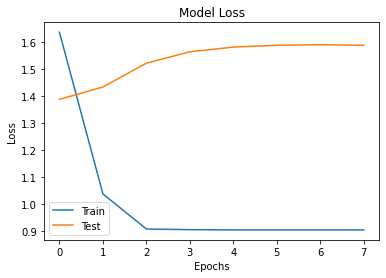

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

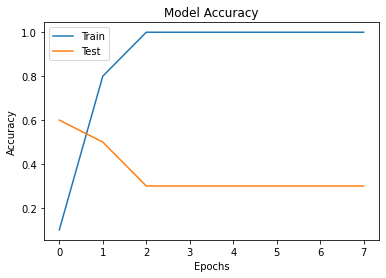

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [25]:
train_loss_vg, train_acc_vg = model.evaluate(train_images, train_labels, verbose=2)
test_loss_vg, test_acc_vg = model.evaluate(test_images, test_labels, verbose=2)
time_vg = perf_counter() - start_time
print(time_vg)

1/1 - 0s - loss: 0.9048 - accuracy: 1.0000
1/1 - 0s - loss: 1.5873 - accuracy: 0.3000
12.244261787011055


## Modelo ResNet

In [26]:
start_time = perf_counter()

pre_trained_model = ResNet50(include_top=False, pooling='avg')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_3 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)             

In [27]:
history = model.fit(train_images, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(test_images, test_labels))   

Epoch 1/8
1/1 [==============================] - 1s 952ms/step - loss: 1.5032 - accuracy: 0.4000 - val_loss: 1.6099 - val_accuracy: 0.3000
Epoch 2/8
1/1 [==============================] - 0s 201ms/step - loss: 1.0235 - accuracy: 0.9000 - val_loss: 1.5925 - val_accuracy: 0.5000
Epoch 3/8
1/1 [==============================] - 0s 206ms/step - loss: 0.9330 - accuracy: 1.0000 - val_loss: 1.5852 - val_accuracy: 0.3000
Epoch 4/8
1/1 [==============================] - 0s 207ms/step - loss: 0.9055 - accuracy: 1.0000 - val_loss: 1.5811 - val_accuracy: 0.3000
Epoch 5/8
1/1 [==============================] - 0s 200ms/step - loss: 0.9054 - accuracy: 1.0000 - val_loss: 1.5779 - val_accuracy: 0.3000
Epoch 6/8
1/1 [==============================] - 0s 212ms/step - loss: 0.9052 - accuracy: 1.0000 - val_loss: 1.5755 - val_accuracy: 0.3000
Epoch 7/8
1/1 [==============================] - 0s 197ms/step - loss: 0.9051 - accuracy: 1.0000 - val_loss: 1.5742 - val_accuracy: 0.3000
Epoch 8/8
1/1 [============

### Evaluating the Resnet CNN Model Performance

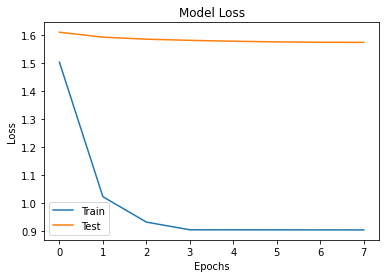

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

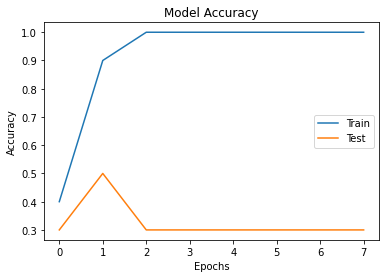

In [29]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [30]:
train_loss_rn, train_acc_rn = model.evaluate(train_images, train_labels, verbose=2)
test_loss_rn, test_acc_rn = model.evaluate(test_images, test_labels, verbose=2)
time_rn = perf_counter() - start_time
print(time_rn)

1/1 - 0s - loss: 1.4982 - accuracy: 0.3000
1/1 - 0s - loss: 1.5739 - accuracy: 0.3000
10.711762607999844


## Modelo InceptionV3

In [31]:
start_time = perf_counter()

pre_trained_model = InceptionV3(include_top=False, weights="imagenet", pooling='avg', classifier_activation='softmax')

model = models.Sequential([
    pre_trained_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(2048, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.layers[0].trainable = False

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_6 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_98 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_99 (Batc (None, 1024)             

### Evaluating the InceptionV3 CNN Model Performance

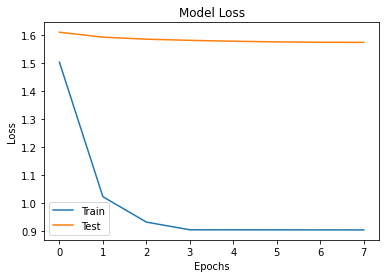

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

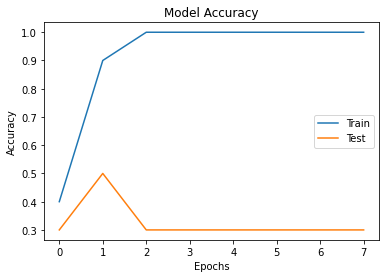

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

In [34]:
train_loss_iv, train_acc_iv = model.evaluate(train_images, train_labels, verbose=2)
test_loss_iv, test_acc_iv = model.evaluate(test_images, test_labels, verbose=2)
time_iv = perf_counter() - start_time
print(time_iv)

1/1 - 0s - loss: 1.6023 - accuracy: 0.3000
1/1 - 0s - loss: 1.6161 - accuracy: 0.2000
5.817704162996961


In [ ]:
cluster = TFCluster.run(sc, main_fun, args, args.cluster_size, num_ps=0, tensorboard=args.tensorboard, input_mode=TFCluster.InputMode.SPARK, master_node='chief')

# Note: need to feed extra data to ensure that each worker receives sufficient data to complete epochs
# to compensate for variability in partition sizes and spark scheduling

cluster.train(images_labels, args.epochs)
cluster.shutdown()


## Sumary  

In [35]:
print("===========================================================================")
print("===============  Compare CNN Algorithms Acurancy and Time =================")
print()
print("   Dataset size = ",SIZE_OF_DATASET,"   Train sample = ",TRAIN_SAMPLE*100,"%  Test sample = ",TEST_SAMPLE*100,"%")
print("   Image size: (%d,%d)   Batch size = %d         Epochs = %d        " % (IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, EPOCHS))
print()
print("Processing images:                                          time = %3.1f s" % (time_ip))
print("Simple Model:         train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_sm, test_acc_sm, time_sm))
print("Complex Model:        train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_cm, test_acc_cm, time_cm))
print("VGG19:                train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_vg, test_acc_vg, time_vg))
print("ResNet50:             train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_rn, test_acc_rn, time_rn))
print("InceptionV3:          train_acc = %1.2f    test_acc = %1.2f   time = %3.1f s" % (train_acc_iv, test_acc_iv, time_iv))
print("===========================================================================")

===============  Compare CNN Algorithms Acurancy and Time =================

   Dataset size =  4510    Train sample =  80.0 %  Test sample =  20.0 %
   Image size: (224,224)   Batch size = 10         Epochs = 8        

Processing images:                                          time = 4.6 s
Simple Model:         train_acc = 0.30    test_acc = 0.30   time = 2.6 s
Complex Model:        train_acc = 0.30    test_acc = 0.30   time = 9.2 s
VGG19:                train_acc = 1.00    test_acc = 0.30   time = 12.2 s
ResNet50:             train_acc = 0.30    test_acc = 0.30   time = 10.7 s
InceptionV3:          train_acc = 0.30    test_acc = 0.20   time = 5.8 s


In [36]:
spark.stop()